In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import random
from scipy.stats import expon, geom
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from scipy import stats
import pointproc as pp
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import UnivariateSpline
plt.style.use('pcb')

from utils import *
from loaders import *
from stan import *

In [2]:
durations_root = 'data/tungsten recordings/durations/'
durdose_root = 'data/tungsten recordings/doses/'

spikefiles_dur = sorted(get_filenames(durations_root, 'SPK'))
stimfiles_dur = sorted(get_filenames(durations_root, 'STIM'))

spikefiles_do = sorted(get_filenames(durdose_root, 'SPK'))
stimfiles_do = sorted(get_filenames(durdose_root, 'STIM'))

In [3]:
dudoe = DoseDurationExperiment(spikefiles_do[:], stimfiles_do[:])
due = DurationExperiment(spikefiles_dur, stimfiles_dur)

In [4]:
def dur2str(dur):
    if dur < 1:
        dur_str = str(int(dur*1000)) + 'ms'
    else:
        dur_str = str(int(dur)) + 's'
    
    return dur_str

doses = ['10pg','100pg','1ng']
durations = ['20ms','200ms','2000ms']
#GHjXxh5u
durations_long = [0.003,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5]

In [5]:
def get_kde(tarr, spiketrain, bw=0.05):
    if not callable(bw):
        scales = bw
    else:
        scales = bw(spiketrain)[:,None]
    return norm.pdf(tarr, loc=spiketrain[:,None], scale=scales).sum(axis=0)

In [6]:
def test_res_2_text(res):
    pval = res.pvalue
    
    if pval < 1e-3:
        return '***'
    elif pval < 1e-2:
        return '**'
    elif pval < 5e-2:
        return '*'
    else:
        return ''

def rasters_from_responses(ax, responses, dur, xmin=-0.11, xmax=0.2, plot_ends=True, plot_stim=True, align='stim_end'):
    end = np.nanmedian(apply_func(responses, find_end, dur))

    if align == 'stim_end':
        spiketrains = [x.spiketrain - x.stim_end for x in responses]
    elif align == 'resp_end':
        spiketrains = [x.spiketrain - (x.stim_start + end) for x in responses]
    
#     if dur == 2:
#         spiketrains = [x for x in spiketrains if ((x > 0) & (x < 0.5)).sum() < 10]
    
    ax.eventplot(spiketrains, color='black', lw=0.8);

    if plot_stim:
        ax.axvspan(-dur, 0, color='C0', alpha=0.3)

    ax.set_xlim(xmin, xmax)

    if plot_ends:
        ax.axvline(end - dur, color='red')
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
def inh_reb_counts(experiment, keys, durs):
    inh_counts = []
    reb_counts = []

    for dur, key in zip(durs, keys):
        responses = experiment[key]
        
        dur_str = str(int(dur*1000)) + 'ms'

        end = np.nanmedian(apply_func(responses, find_end, dur))

        spiketrains = [x.spiketrain - (x.stim_start + end) for x in responses]

        inh_counts.append(np.array([((x > 0.1) & (x < 0.4)).sum() for x in spiketrains]))
        reb_counts.append(np.array([((x > 1) & (x < 3)).sum() for x in spiketrains]))
    
    return inh_counts, reb_counts

def plot_inh_reb(axes, experiment, keys, durs, sig_positions, legend):
    inh_counts, reb_counts = inh_reb_counts(experiment, keys, durs)
    
    significance_levels = [test_res_2_text(stats.wilcoxon(i/0.4, r/2)) for i, r in zip(inh_counts, reb_counts)]
    
    inh_counts_mean = pd.Series(inh_counts).map(np.mean)
    reb_counts_mean = pd.Series(reb_counts).map(np.mean)
    
    params = {'ms': 4, 'marker': 'o'}
    
    axes[0].plot(inh_counts_mean / 0.4, label='inh', c='C3', **params)
    axes[0].plot(reb_counts_mean / 2, label='reb', c='C2', **params)
    diff = (reb_counts_mean / 2) - (inh_counts_mean / 0.4)
    axes[1].plot(diff, label='reb-inh', c='C0', **params)
    
    if legend:
        axes[0].legend(frameon=False)
        axes[1].legend(frameon=False)
    
    for i, (sig, sig_pos) in enumerate(zip(significance_levels, sig_positions)):
        axes[1].text(i, sig_pos, sig, ha='center')
    

def plot_inh_reb_dur(axes, sig_positions=None):
    if sig_positions is None:
        sig_positions = [0] * len(durations_long)
    
    dur_strings = [str(int(x*1000))+'ms' for x in durations_long]
    plot_inh_reb(axes, due, dur_strings, durations_long, sig_positions, legend=True)

    for ax in axes[:1]:
        ax.set_xticklabels([])
#     axes[2].tick_params(axis='x', labelrotation = 45)
    axes[1].set_xticks(range(11))
    axes[1].set_xticklabels([dur2str(x) for x in durations_long], rotation=90)

def plot_inh_reb_dose(axes, dur, sig_positions=None):
    if sig_positions is None:
        sig_positions = [0] * 3
    
    dur_str = str(int(dur*1000))+'ms'
    dur_strings = [dur_str] * 3
    keys = [(dose, dur_str) for dose in doses]
    plot_inh_reb(axes, dudoe, keys, [dur]*3, sig_positions, legend=False)

    for ax in axes[:2]:
        ax.set_xticklabels([])


def plot_inh_reb_durdose(axes, dose, sig_positions=None):
    if sig_positions is None:
        sig_positions = [0] * 3
    
    durations = ['20ms','200ms','2000ms']
    keys = [(dose, dur_str) for dur_str in durations]
    plot_inh_reb(axes, dudoe, keys, [0.02, 0.2, 2], sig_positions, legend=False)
    

def plot_rasters(axes, *args, **kwargs):
    for dur, ax in zip(durations_long, axes):
        dur_str = str(int(dur*1000)) + 'ms'
        rasters_from_responses(ax, due[dur_str], dur, *args, **kwargs)
    
    for ax in axes[:-1]:
        ax.set_xticklabels([])
    

def plot_dudoe_dur(axes, dur, *args, **kwargs):
    for ax, dose in zip(axes, doses):
        dur_str = str(int(dur*1000)) + 'ms'
        rasters_from_responses(ax, dudoe[dose, dur_str], dur, *args, **kwargs)
    
    for ax in axes[:-1]:
        ax.set_xticklabels([])

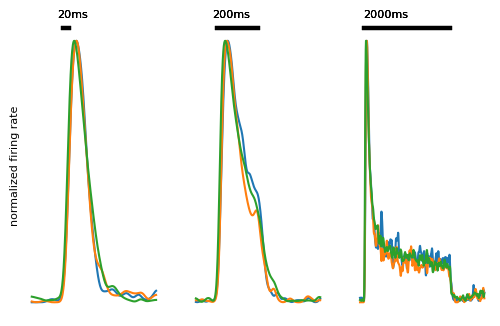

In [7]:
def plot_shapes(axes, text_pos=1.09):
    xlims = [(-0.1, 0.3), (-0.1, 0.5), (-0.1, 2.8)]
    durations = ['20ms','200ms','2000ms']
    
    for ax, dur, xlim in zip(axes, durations, xlims):
        for dose in ['10pg','100pg','1ng']:
            kdes = []
            tt = np.linspace(xlim[0], xlim[1], 500)
            for rec in dudoe[dose, dur]:
                kde = rec.kde(tt, shift=True, bw=0.01)
                kdes.append(kde)

            kdes = np.array(kdes)
            mean_kde = kdes.mean(axis=0)
            ax.plot(tt, mean_kde / mean_kde.max(), label=dose)
            
            dur_num = float(dur[:-2])/1000
            ax.plot([0, dur_num], [1.05, 1.05], color='black', lw=3)
            ax.text(-0.02, text_pos, f'{dur_num*1000:.0f}ms', ha='left')
            despine_ax(ax)
    
    axes[0].set_ylabel('normalized firing rate')
        
fig, axes = plt.subplots(ncols=3)
plot_shapes(axes)

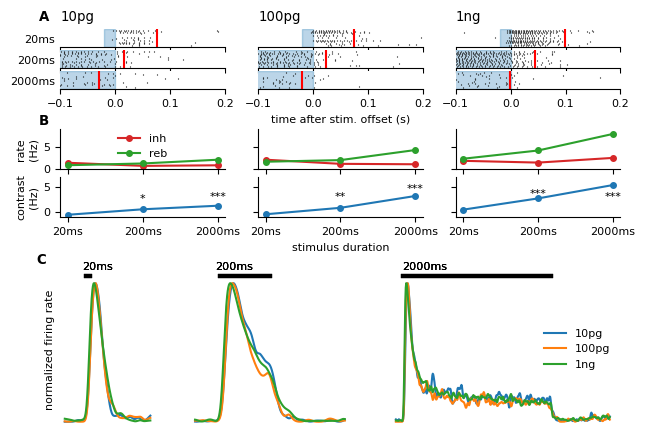

In [8]:
fig = plt.figure(figsize=(5.6, 4))

gs_raster = fig.add_gridspec(3, 3, top=1, right=1, left=0.0, bottom=0.85)

for i, dur in enumerate([0.02, 0.2, 2]):
    for j, dose in enumerate(['10pg','100pg','1ng']):
        ax = fig.add_subplot(gs_raster[i,j])
        if i != 2:
            ax.set_xticklabels([])
        dur_str = str(int(dur*1000)) + 'ms'
        rasters_from_responses(ax, dudoe[dose, dur_str], dur, xmin=-0.1, xmax=.2)
        
        if i == 2 and j == 1:
            ax.set_xlabel('time after stim. offset (s)')
            
        if i == 0:
            ax.set_title(dose, loc='left')
        
        if j == 0:
            dur_str = f'{dur*1000:.0f}ms'
            ax.text(s=dur_str, x=-0.11, y=10, ha='right')
            
        if i == 0 and j == 0:
            ax.set_title('A', x=-0.1, y=1, weight='bold')
            
gs_inhib = fig.add_gridspec(2, 3, top=0.75, right=1, left=0.0, bottom=0.53)
axes = np.array([[fig.add_subplot(gs_inhib[j,i]) for i in range(3)] for j in range(2)])

plot_inh_reb_durdose(axes[:,0], '10pg', sig_positions=[3.5, 2, 2.5])
plot_inh_reb_durdose(axes[:,1], '100pg', sig_positions=[3.5, 2.5, 4])
plot_inh_reb_durdose(axes[:,2], '1ng', sig_positions=[2.5, 3, 2.5])

axes[0,0].set_ylabel('rate\n(Hz)')
axes[1,0].set_ylabel('contrast\n(Hz)')

axes[0,0].set_title('B', x=-0.1, y=.9, weight='bold')
axes[0,0].legend(frameon=False)

for i, ax in enumerate(axes[0,:]):
    ax.set_ylim(0, 9)
    
    if i != 0:
        ax.set_yticklabels([])

for i, ax in enumerate(axes[1,:]):
    ax.set_ylim(-1, 7)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['20ms','200ms','2000ms'])
    
    if i != 0:
        ax.set_yticklabels([])
    
axes[1,1].set_xlabel('stimulus duration')

gs_shapes = fig.add_gridspec(1, 3, top=0.4, right=1, left=0.0, bottom=0., width_ratios=[0.4,0.7,1])


axes = np.array([fig.add_subplot(gs_shapes[i]) for i in range(3)])
plot_shapes(axes, text_pos=1.1)
axes[0].set_title('C', x=-0.2, y=.98, weight='bold')
axes[2].legend(loc='center right', frameon=False)

# plt.savefig('img/doses_main.png')

In [9]:
def kdes_list(tarr, responses, bw=0.1, align='start'):
    kdes = []
    for resp in responses:
        if align == 'start':
            st = resp.spiketrain - resp.stim_start
        elif align == 'end':
            st = resp.spiketrain - resp.stim_end
        
        kde = get_kde(tarr, st, bw=bw)
        kdes.append(kde)
    
    return kdes

In [10]:
# fig, axes = plt.subplots(nrows=len(durations_long), sharex=True)

tarr = np.linspace(-1, 7, 1000)

kdes = {}

for dur in durations_long:
    dur_str = str(int(dur*1000)) + 'ms'
    kdl = kdes_list(tarr, due[dur_str], bw=0.1)
    kdes[dur] = {
        'kdes': kdl,
        'mean': np.mean(kdl, axis=0)
    }

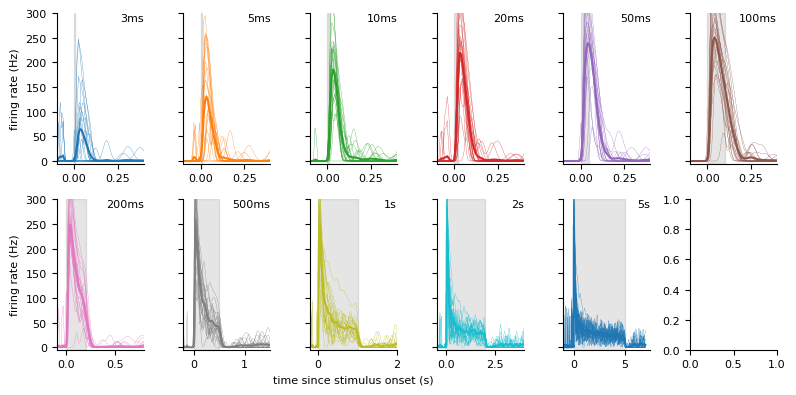

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(8,4))

def plot_dur(axes, start=-1, end=7, bw=0.05):
    tarr = np.linspace(start, end, 1000)
    
    xlims = [
        (-0.1, 0.4),
        (-0.1, 0.4),
        (-0.1, 0.4),
        (-0.1, 0.4),
        (-0.1, 0.4),
        (-0.1, 0.4),
        (-0.1, 0.8),
        (-0.2, 1.5),
        (-0.2, 2),
        (-0.5, 4),
        (-1, 7.5)]
    
    kdes = {}
    
    bws = [0.01]*6 + [0.05]*5
    
    for dur, bw in zip(durations_long, bws):
        dur_str = str(int(dur*1000)) + 'ms'
        kdl = kdes_list(tarr, due[dur_str], bw=lambda x: bw_func(x, max_bw=0.05))
#         kdl = kdes_list(tarr, due[dur_str], bw=bw)
        kdes[dur] = {
            'kdes': kdl,
            'mean': np.mean(kdl, axis=0)
        }
    
    for i, (dur, ax, xlim) in enumerate(zip(durations_long, axes, xlims)):
        color = f'C{i}'
#         color = 'C0'
        dur_str = str(int(dur*1000)) + 'ms'
#         ax.axvspan(0, dur, alpha=0.1)
            
        ax.axvspan(0,dur, color='black', alpha=0.1)
        
        ax.plot(tarr, kdes[dur]['mean'], c=color)
#         ax.set_title(dur_str, loc='right', fontsize=10)
        ax.text(1,1, dur2str(dur), ha='right', va='top', transform=ax.transAxes)

        for kde in kdes[dur]['kdes']:
            ax.plot(tarr, kde, c=color, lw=0.2)
        ax.set_xlim(xlim)
        ax.set_ylim(-5, 300)
#         ax.axvspan(0, dur)
        
        if i == 8:
            ax.set_xlabel('time since stimulus onset (s)')
        
        ax.set_yticks([0, 50, 100, 150, 200, 250, 300])
        
        if i != 0 and i != 6:
            ax.set_yticklabels([])
        if i == 0 or i == 6:
            ax.set_ylabel('firing rate (Hz)')

plot_dur(axes.flat)
plt.tight_layout()

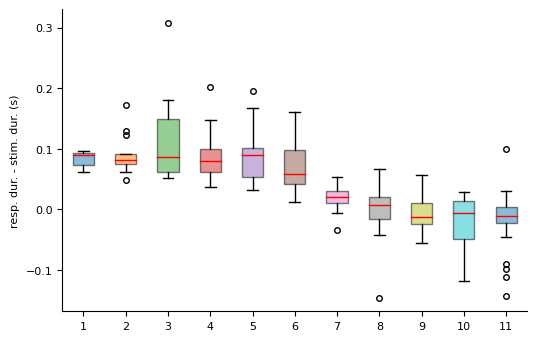

In [12]:
def plot_dur_ends(ax):
    ends = []

    for dur in durations_long:
        dur_str = str(int(dur*1000)) + 'ms'
        ends_full = apply_func(due[dur_str], find_end, dur) - dur
        ends.append(ends_full[ends_full == ends_full])

    bplot = ax.boxplot(ends, patch_artist=True, medianprops={'color': 'red'}, flierprops={'ms': 4})
    
    for seg in ['boxes']:
        for i, patch in enumerate(bplot[seg]):
#             patch.set_edgecolor(f'C{i}')
#             patch.set_lw(2)
            patch.set_facecolor(f'C{i}')
            patch.set_alpha(0.5)
    
    ax.set_ylabel('resp. dur. - stim. dur. (s)')

        
fig, ax = plt.subplots()
plot_dur_ends(ax)

In [13]:
base_root = 'data/base recordings/multiple trials/'
files_base = os.listdir(base_root)
txt_files = sorted([base_root+x for x in files_base if x[-3:] == 'txt'])
abf_files = sorted([base_root+x for x in files_base if x[-3:] == 'abf'])

dur_dose_base = txt_files, abf_files

txt_files_dur, abf_files_dur = dur_dose_base

ix = 6
rec = StabilityRecording(txt_files_dur[ix], abf_files_dur[ix], filtered=False, sig=1)

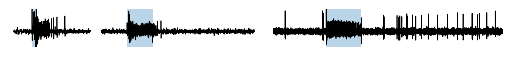

In [14]:
def plot_raw(axes):
    bfafs = [
        (0.1, 0.3),
        (0.2, 0.8),
        (3, 8)
    ]

    for resp_ix, (before, after), ax in zip([2,1,6], bfafs, axes):

        tarr, varr = rec[resp_ix][1].to_arrays(before=before, after=after)
        tarr = tarr - rec[resp_ix][0].stim_start

        varr_filtered = butter_lowpass_filter(varr, 80, 1e4, btype='high')

        ax.plot(tarr, varr_filtered, lw=0.5, color='black')
        ax.set_ylim(-0.7,1)

        despine_ax(ax)
        
    axes[0].axvspan(0, 0.02, alpha=0.3)
    axes[1].axvspan(0, 0.2, alpha=0.3)
    axes[2].axvspan(0, 2, alpha=0.3)
        
fig, axes = plt.subplots(ncols=3, figsize=(6.5,.5), gridspec_kw={'width_ratios': [1,2,3], 'wspace': 0.})

plot_raw(axes)

/opt/anaconda/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Text(0, 0.5, 'contrast (Hz)')

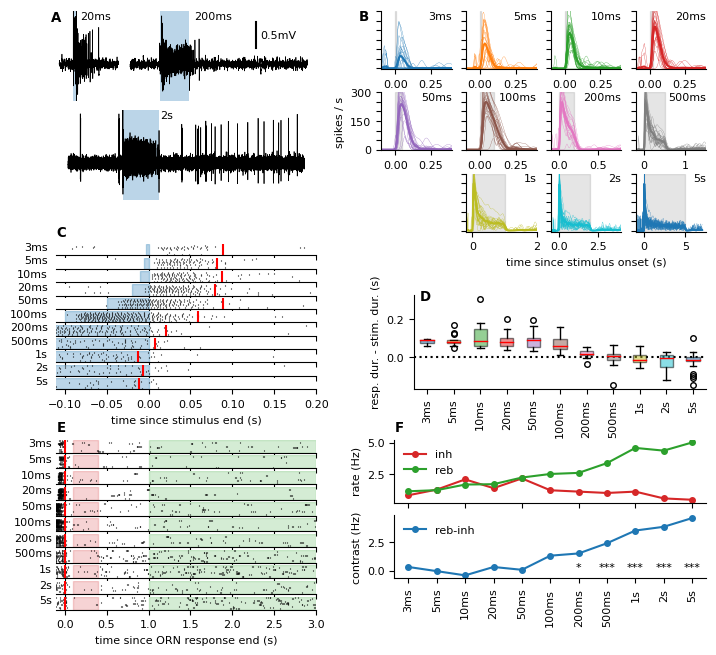

In [15]:
fig = plt.figure(figsize=(6.5, 6.3))

durations_long_str = ['3ms', '5ms', '10ms', '20ms', '50ms', '100ms', '200ms', '500ms', '1s', '2s', '5s']

split_ratio = 0.5

gs_raw = fig.add_gridspec(2,2,top=1, bottom=0.7, left=0., right=0.4, hspace=0.1, wspace=0, width_ratios=[1, 3])

axes = [
    fig.add_subplot(gs_raw[0,0]),
    fig.add_subplot(gs_raw[0,1]),
    fig.add_subplot(gs_raw[1,:])
]

axes[0].text(0.05, .85, '20ms')
axes[1].text(0.23, .85, '200ms')
axes[2].text(2.06, .85, '2s')

plot_raw(axes)

axes[1].plot([0.65,0.65],[0.3,0.8], color='black', lw=1.5)
axes[1].text(0.68, 0.55, '0.5mV', va='center', ha='left')

axes[0].set_title('A', x=0, y=0.8, fontweight='bold')

gs_dur = fig.add_gridspec(3,4,top=1, bottom=0.65, left=0.5, right=1, hspace=0.4)
axes = [fig.add_subplot(gs_dur[0,i]) for i in range(4)] + \
    [fig.add_subplot(gs_dur[1,i]) for i in range(4)] + \
    [fig.add_subplot(gs_dur[2,i+1]) for i in range(3)]

plot_dur(axes)

axes[6].set_ylabel('')
axes[6].set_yticklabels('')
axes[0].set_ylabel('')
axes[0].set_yticklabels('')
axes[4].set_ylabel('spikes / s')
axes[4].set_yticklabels([0,'','',150,'','',300])
axes[8].set_xlabel('')
axes[9].set_xlabel('time since stimulus onset (s)')
# for ax in axes:
#     ax.set_ylim(-5, 150)

axes[0].set_title('B', x=-0.25, y=0.7, fontweight='bold')
    
bottom_row_2 = 0.4
top_row_2 = 0.63

gs_end = fig.add_gridspec(11,1,top=top_row_2, bottom=bottom_row_2, left=0., right=0.4)
axes = [fig.add_subplot(gs_end[i]) for i in range(11)]

plot_rasters(axes)

for ax, dur in zip(axes, durations_long):
#     dur_str = str(int(dur*1000)) + 'ms'
    dur_str = dur2str(dur)
    ax.text(s=dur_str, x=-0.12, y=10, ha='right')
    
axes[0].set_title('C', loc='left', fontweight='bold')
axes[-1].set_xlabel('time since stimulus end (s)')

gs_box = fig.add_gridspec(1,1,top=0.55, bottom=bottom_row_2, left=0.55, right=1)
ax = fig.add_subplot(gs_box[0,0])

plot_dur_ends(ax)
ax.set_title('D', x=0.04, y=0.85, fontweight='bold')
ax.set_xticklabels(durations_long_str, rotation=90)
ax.axhline(0, color='black', linestyle='dotted')

### INHIBITION ###

bottom = 0.05

gs_dur = fig.add_gridspec(11, 1, top=0.32, right=0.4, left=0.0, bottom=bottom)
axes = [fig.add_subplot(gs_dur[i,0]) for i in range(11)]

axes[0].set_title('E', loc='left', fontweight='bold')

axes[-1].set_xlabel('time since ORN response end (s)')

for ax, dur in zip(axes, durations_long):
    dur_str = dur2str(dur)
        
    ax.text(s=dur_str, x=-0.15, y=10, ha='right')

params = dict(
    xmin=-0.1,
    xmax=3,
    plot_ends=False,
    plot_stim=False,
    align='resp_end'
)

plot_rasters(axes, **params)
for ax in axes:
    ax.axvspan(0.1, 0.4, alpha=0.2, color='C3')
    ax.axvspan(1, 3, alpha=0.2, color='C2')
    ax.axvline(0, color='red')
    

gs_inh_dur = fig.add_gridspec(2, 1, top=0.32, left=0.52, bottom=bottom+0.05, right=1)
axes = [fig.add_subplot(gs_inh_dur[i]) for i in range(2)]
plot_inh_reb_dur(axes)

axes[0].set_title('F', loc='left', fontweight='bold')

axes[0].set_ylabel('rate (Hz)')
axes[1].set_ylabel('contrast (Hz)')

# plt.savefig('img/duration_inhibition_raw.png')

# Supplementary figure

In [16]:
folder = 'data/tungsten recordings/airflow control'
files_ac = sorted(get_filenames(folder))

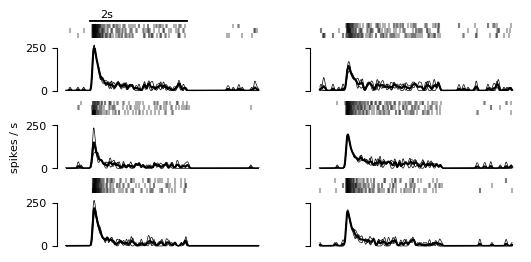

In [17]:
fig, axes = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(6,3), gridspec_kw={'height_ratios': [1,2]*3})


for i, file in enumerate(files_ac):
    col = i // 3
    row = 2 * (i - 3*col)
    ax2, ax1 = axes[row, col], axes[row+1, col]
    
    ax1.set_ylim(0, 250)
    
    spiketrain = pd.read_csv(file, sep='\t')['spike times'].values

    spiketrains = []
    kdes = []

    for s in range(3):
        start = 59.5 + s*62
        end = 63.5 + s*62
        tarr = np.arange(0, end-start, 1e-3)

        spt_tmp = spiketrain[(spiketrain >= start) & (spiketrain < end)] - start
        spiketrains.append(spt_tmp)
        kde = get_kde(tarr, spt_tmp, 0.02)
        kdes.append(kde)
    
    for kde in kdes:
        ax1.plot(tarr, kde, color='black', lw=0.5, clip_on=False)
        
    if col == 1:
        ax1.set_yticklabels([])
    
    despine_ax(ax1, 'b')
    despine_ax(ax2)
        
    ax1.plot(tarr, np.mean(kdes, axis=0), color='black')
    ax2.eventplot(spiketrains, alpha=0.3, color='black')
    
axes[0,0].plot([0.5, 2.5], [3.2,3.2], color='black', lw=2)
axes[0,0].text(0.7, 3.8, '2s')

axes[3,0].set_ylabel('spikes / s');